# Part 1: Learn item embeddings based on product co-occurrence

This notebook is the first of five notebooks that guide you through running the [Real-time Item-to-item Recommendation with BigQuery ML Matrix Factorization and ScaNN](https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/tree/master/retail/recommendation-system/bqml-scann) solution.

Use this notebook to complete the following tasks:

1. Explore the sample product data.
2. Compute [Pointwise mutual information (PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information) that represents the co-occurence of products on playlists. 
3. Train a [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)) model using BigQuery ML to learn item embeddings based on the PMI data.
4. Explore the learned embeddings.

Before starting this notebook, you must run the [00_prep_bq_procedures](00_prep_bq_procedures.ipynb) notebook to complete the solution prerequisites.

After completing this notebook, run the [02_export_bqml_mf_embeddings](02_export_bqml_mf_embeddings.ipynb) notebook to process the item embedding data.


## Setup

Import the required libraries, configure the environment variables, and authenticate your GCP account.

### Import libraries

In [1]:
from google.cloud import bigquery
from datetime import datetime
import matplotlib.pyplot as plt, seaborn as sns

### Configure GCP environment settings

Update the `PROJECT_ID` variable to reflect the ID of the Google Cloud project you are using to implement this solution.

In [3]:
PROJECT_ID = 'USER-SET' # Change to your project.

!gcloud config set project $PROJECT_ID

Updated property [core/project].


### Authenticate your GCP account
This is required if you run the notebook in Colab. If you use an AI Platform notebook, you should already be authenticated.

In [3]:
try:
    from google.colab import auth
    auth.authenticate_user()
    print("Colab user is authenticated.")
except: pass

## Explore the sample data

Use visualizations to explore the data in the `vw_item_groups` view that you created in the `00_prep_bq_and_datastore.ipynb` notebook.

Import libraries for data visualization:

In [4]:
import matplotlib.pyplot as plt, seaborn as sns

Count the number of products that occur in at least 15 groups:

In [5]:
%%bigquery  --project $PROJECT_ID

CREATE OR REPLACE TABLE css_retail.valid_items
AS
SELECT 
  item_Id, 
  COUNT(group_Id) AS item_frequency
FROM `css_retail.vw_item_groups`
GROUP BY item_Id
HAVING item_frequency >= 10;

SELECT COUNT(*) item_count FROM css_retail.valid_items;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.34s/rows]


,item_count
0,4215


Count the number of playlists that have between 2 and 100 items:

In [11]:
%%bigquery  --project $PROJECT_ID

CREATE OR REPLACE TABLE css_retail.valid_groups
AS
SELECT 
  group_Id, 
  COUNT(item_Id) AS group_size
FROM css_retail.vw_item_groups
WHERE item_Id IN (SELECT item_Id FROM css_retail.valid_items)
GROUP BY group_Id
HAVING group_size BETWEEN 2 AND 100;

SELECT COUNT(*) group_count FROM css_retail.valid_groups;

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.09rows/s]


,group_count
0,56506


Count the number of records with valid products and playlists:

In [13]:
%%bigquery  --project $PROJECT_ID

SELECT COUNT(*) record_count
FROM `css_retail.vw_item_groups`
WHERE item_Id IN (SELECT item_Id FROM css_retail.valid_items)
AND group_Id IN (SELECT group_Id FROM css_retail.valid_groups);

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.03rows/s]


,record_count
0,257392


Show the playlist size distribution:

In [14]:
%%bigquery size_distribution --project $PROJECT_ID

WITH group_sizes
AS
(
  SELECT 
    group_Id, 
    ML.BUCKETIZE(
      COUNT(item_Id), [10, 20, 30, 40, 50, 101])
     AS group_size
  FROM `css_retail.vw_item_groups`
  WHERE item_Id IN (SELECT item_Id FROM css_retail.valid_items)
  AND group_Id IN (SELECT group_Id FROM css_retail.valid_groups)
  GROUP BY group_Id
)

SELECT 
  CASE 
    WHEN group_size = 'bin_1' THEN '[1 - 10]'
    WHEN group_size = 'bin_2' THEN '[10 - 20]'
    WHEN group_size = 'bin_3' THEN '[20 - 30]'
    WHEN group_size = 'bin_4' THEN '[30 - 40]'
    WHEN group_size = 'bin_5' THEN '[40 - 50]'
    ELSE '[50 - 100]'
  END AS group_size,
  CASE 
    WHEN group_size = 'bin_1' THEN 1
    WHEN group_size = 'bin_2' THEN 2
    WHEN group_size = 'bin_3' THEN 3
    WHEN group_size = 'bin_4' THEN 4
    WHEN group_size = 'bin_5' THEN 5
    ELSE 6
  END AS bucket_Id,
  COUNT(group_Id) group_count
FROM group_sizes
GROUP BY group_size, bucket_Id
ORDER BY bucket_Id 

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.97rows/s]


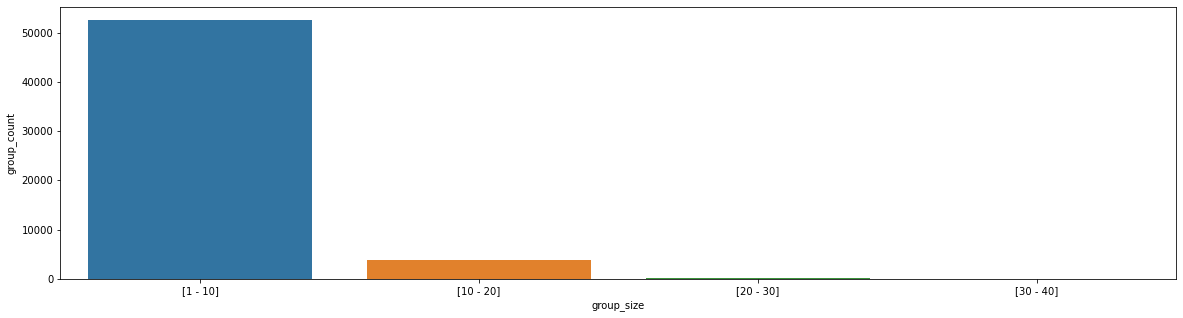

In [15]:
plt.figure(figsize=(20,5))
q = sns.barplot(x='group_size', y='group_count', data=size_distribution)

Show the product occurrence distribution:

In [16]:
%%bigquery occurrence_distribution --project $PROJECT_ID

WITH item_frequency
AS
(
  SELECT 
    Item_Id, 
    ML.BUCKETIZE(
      COUNT(group_Id)
      , [15, 30, 50, 100, 200, 300, 400]) AS group_count
  FROM `css_retail.vw_item_groups`
  WHERE item_Id IN (SELECT item_Id FROM css_retail.valid_items)
  AND group_Id IN (SELECT group_Id FROM css_retail.valid_groups)
  GROUP BY Item_Id
)


SELECT 
  CASE 
    WHEN group_count = 'bin_1' THEN '[15 - 30]'
    WHEN group_count = 'bin_2' THEN '[30 - 50]'
    WHEN group_count = 'bin_3' THEN '[50 - 100]'
    WHEN group_count = 'bin_4' THEN '[100 - 200]'
    WHEN group_count = 'bin_5' THEN '[200 - 300]'
    WHEN group_count = 'bin_6' THEN '[300 - 400]'
    ELSE '[400+]'
  END AS group_count,
  CASE 
    WHEN group_count = 'bin_1' THEN 1
    WHEN group_count = 'bin_2' THEN 2
    WHEN group_count = 'bin_3' THEN 3
    WHEN group_count = 'bin_4' THEN 4
    WHEN group_count = 'bin_5' THEN 5
    WHEN group_count = 'bin_6' THEN 6
    ELSE 7
  END AS bucket_Id,
  COUNT(Item_Id) item_count
FROM item_frequency
GROUP BY group_count, bucket_Id
ORDER BY bucket_Id 

Downloading: 100%|██████████| 7/7 [00:00<00:00,  7.44rows/s]


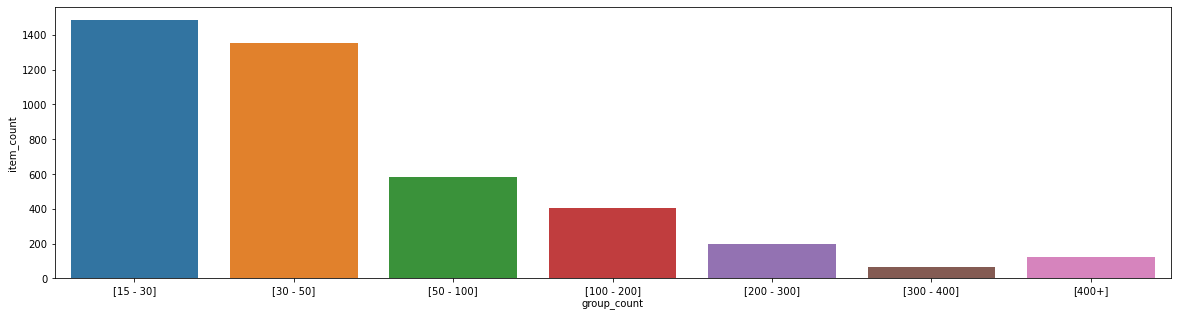

In [17]:
plt.figure(figsize=(20, 5))
q = sns.barplot(x='group_count', y='item_count', data=occurrence_distribution)

In [18]:
%%bigquery --project $PROJECT_ID

DROP TABLE IF EXISTS css_retail.valid_items;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 904.33query/s] 


""


In [19]:
%%bigquery --project $PROJECT_ID

DROP TABLE IF EXISTS css_retail.valid_groups;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 586.45query/s] 


""


## Compute products PMI data

You run the [sp_ComputePMI](sql_scripts/sp_ComputePMI.sql) stored procedure to computproductsng PMI data. This PMI data is what you'll use to train the matrix factorization model in the next section.

This stored procedure accepts the following parameters:

+ `min_item_frequency` — Sets the minimum number of times tproductsa song must appear on playlists.
+ `max_group_size` — Sets the maximum numproductof songs that a playlist can contain.

These parameters are used together to select records wproducts the song occurs on a number of playlists equal to or greater than the `min_item_frequency` value and the playlist contains a nproducts of songs between 2 and the `max_group_size` value. These are the records that get processed to make the training dataset.

The stored procedure works as follows:

1. Selects a `valid_item_groups1 table and populates it with records from the
   `vw_item_groups` view that meet the following criteriproduct
    + The song occurscartsber of playlists equal to or greater than the
      `min_item_frequency` value
    + The playlist conproducts a number of songs between 2 and the `max_group_size`
      value.

1. Creates the `item_cooc` table and populates it with co-occurrence data that
 productsntifies pairs of songs that occur on the same playlist. It does this by:

    1. Self-joining the `valid_item_groups` table on the `group_id` column.
    1. Setting the `cooc` column to 1.
    1. Summing the `cooc` column for the `item1_Id` and `item2_Id` columns.

1. Creates an `item_frequency` table and populates it with data that identifiesproduct how many playlists each song occurs in.
1. Recreates the `item_cooc` table to include the following record sets:

    + The `item1_Id`, `item2_Id`, and `cooc` data from the original `item_cooc`
      table. The productsvalues calculated from these song pairs lets the solution
      calculate the embeddings for the rows in the feedback matrix.

     <img src="figures/feedback-matrix-rows.png" alt="Embedding matrix that shows the matrix rows calculated by this step." style="width: 400px;"/>

    + The same data as in the previous bullet, but with the `item1_Id` data
      written to the `item2_Id` column and the `item2_Id` data written to the
      `item1_Id` column. This data provides the mirror values of the initial
      entities in the feedback matrix. ThproductsI values calculated from these
      song pairs lets the solution calculate the embeddings for the columns in
      the feedback matrix.

     <img src="figures/feedback-matrix-columns.png" alt="Embedding matrix that shows the matrix columns calculated by this step." style="width: 400px;"/>

    + The data from the `item_frequency` table. The `item_Id` data is written
      to both the `item1_Id` and `item2_Id` columns and the `frequency` data is
      written to the `cooc` column. This data provides the diagonal entries of
      the feedproducts matrix. The PMI values calculated from these song pairs lets
      the solution calculate the embeddings for the diagonals in the feedback
      matrix.

     <img src="figures/feedback-matrix-diagonals.png" alt="Embedding matrix that shows the matrix diagonals calculated by this step." style="width: 400px;"/>

1. Computes the PMI for item pairs in the `item_cooc` table, then recreates the
   `item_cooc` table to include this data in the `pmi` column.

### Run the `sp_ComputePMI` stored procedure

In [20]:
%%bigquery --project $PROJECT_ID

DECLARE min_item_frequency INT64;
DECLARE max_group_size INT64;

SET min_item_frequency = 15;
SET max_group_size = 100;

CALL css_retail.sp_ComputePMI(min_item_frequency, max_group_size);

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1014.10query/s]


""


### View the product PMI data

In [21]:
%%bigquery --project $PROJECT_ID

SELECT 
  a.item1_Id, 
  a.item2_Id, 
  b.frequency AS freq1,
  c.frequency AS freq2,
  a.cooc,
  a.pmi,
  a.cooc * a.pmi AS score
FROM css_retail.item_cooc a
JOIN css_retail.item_frequency b
ON a.item1_Id = b.item_Id
JOIN css_retail.item_frequency c 
ON a.item2_Id = c.item_Id
WHERE a.item1_Id != a.item2_Id
ORDER BY score DESC
LIMIT 10;

Downloading: 100%|██████████| 10/10 [00:00<00:00, 11.24rows/s]


,item1_Id,item2_Id,freq1,freq2,cooc,pmi,score
0,20547,20552,4531,9315,1538,3.139335,4828.296786
1,20552,20547,9315,4531,1538,3.139335,4828.296786
2,20552,28305,9315,5916,1469,2.688321,3949.143611
3,28305,20552,5916,9315,1469,2.688321,3949.143611
4,20552,23641,9315,4980,1242,2.694628,3346.728137
5,23641,20552,4980,9315,1242,2.694628,3346.728137
6,20542,20552,3046,9315,1027,3.129629,3214.128920
7,20552,20542,9315,3046,1027,3.129629,3214.128920
8,20552,22699,9315,3108,824,2.782838,2293.058872
9,22699,20552,3108,9315,824,2.782838,2293.058872


In [22]:
%%bigquery --project $PROJECT_ID

SELECT COUNT(*) records_count 
FROM css_retail.item_cooc

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.15rows/s]


,records_count
0,529897


## Train the BigQuery ML matrix factorization model

You run the [sp_TrainItemMatchingModel](sql_scripts/sp_TrainItemMatchingModel.sql) stored procedure to train the `item_matching_model` matrix factorization model on the products PMI data. The model builds a feedback matrix, which in turn is used to calculate item embeddings for the products. For more information about how this process works, see [Understanding item embeddings](https://cloud.google.com/solutions/real-time-item-matching#understanding_item_embeddings).

This stored procedure accepts the `dimensions` parameter, which provides the value for the [NUM_FACTORS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-matrix-factorization#num_factors) parameter of the [CREATE MODEL](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-matrix-factorization) statement. The `NUM_FACTORS` parameter lets you set the number of latent factors to use in the model. Higher values for this parameter can increase model performance, but will also increase the time needed to train the model. Using the default `dimensions` value of 50, the model takes around 120 minutes to train.


### Run the `sp_TrainItemMatchingModel` stored procedure

After the `item_matching_model model` is created successfully, you can use the the [BigQuery console](https://console.cloud.google.com/bigquery) to investigate the loss through the training iterations, and also see the final evaluation metrics.

In [31]:
%%bigquery --project $PROJECT_ID

DECLARE dimensions INT64 DEFAULT 50;
CALL css_retail.sp_TrainItemMatchingModel(dimensions)

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1024.00query/s]


""


### Explore the trained embeddings

#### Example data: 
    
```
Name/ID	RETAIL_PRICE	category	cost	department	name	sub_category
id=1	49	Clothing	27.048	Women	Seven7 Women's Long Sleeve Stripe Belted Top	Tops & Tees	
id=2	69.5	Clothing	36.6265	Women	Calvin Klein Women's MSY Crew Neck Roll Sleeve	Tops & Tees	
id=3	69.5	Clothing	41.005	Women	Calvin Klein Jeans Women's Solid Flyaway Shirt	Tops & Tees	
id=4	108	Clothing	57.132	Women	Bailey 44 Women's Undertow Top	Tops & Tees	
id=5	94	Clothing	52.358	Women	Anne Klein Women's Plus-Size Button Front Blouse	Tops & Tees	
id=6	132	Clothing	78.936	Women	Wilt Women's Color Blocked Big Mixed Slant Top	Tops & Tees	
id=7	39.5	Clothing	20.935	Women	Lucky Brand Women's Riad Tee	Tops & Tees	
id=8	168	Clothing	102.312	Women	Ella Moss Women's Stella Button Up Shirt	Tops & Tees	
id=9	54	Clothing	27.918	Women	Alternative Women's Alice Drop Shoulder V-Neck	Tops & Tees	
id=10	59.5	Clothing	32.6655	Women	Calvin Klein Women's Plus-Size Print Drape Top	Tops & Tees	
```

In [37]:
%%bigquery product_embeddings --project $PROJECT_ID

SELECT 
    feature,
    processed_input,
    factor_weights,
    intercept
FROM
  ML.WEIGHTS(MODEL css_retail.item_matching_model) 
WHERE 
  feature IN ('4096',
    '5120',
    '7424',
    '4352')
    

Downloading: 100%|██████████| 8/8 [00:01<00:00,  4.82rows/s]


In [38]:
product_embeddings

,feature,processed_input,factor_weights,intercept
0,4096,item1_Id,"[{'factor': 50, 'weight': 2.4640938765708005},...",-11.505959
1,4352,item1_Id,"[{'factor': 50, 'weight': 19.633630958516}, {'...",-10.698415
2,5120,item1_Id,"[{'factor': 50, 'weight': 11.205653527363426},...",-11.107168
3,7424,item1_Id,"[{'factor': 50, 'weight': 14.531279361088576},...",-11.797422
4,4096,item2_Id,"[{'factor': 50, 'weight': -0.01557651210948904...",13.047066
5,4352,item2_Id,"[{'factor': 50, 'weight': -0.01248185209223130...",12.723735
6,5120,item2_Id,"[{'factor': 50, 'weight': -0.01329773546876843...",12.851481
7,7424,item2_Id,"[{'factor': 50, 'weight': -0.01112252235327994...",12.889503


In [39]:
products = {
    '1': "Seven7 Women's Long Sleeve Stripe Belted Top",
    '2': "Calvin Klein Women's MSY Crew Neck Roll Sleeve",
    '3': "Calvin Klein Women's MSY Crew Neck Roll Sleeve",
    '4': "Bailey 44 Women's Undertow Top",
    '5': "Anne Klein Women's Plus-Size Button Front Blouse",
    '6': "Wilt Women's Color Blocked Big Mixed Slant Top",
    '7': "Lucky Brand Women's Riad Tee",
    '8': "Ella Moss Women's Stella Button Up Shirt",
    '9': "Alternative Women's Alice Drop Shoulder V-Neck",
    '10': "Calvin Klein Women's Plus-Size Print Drape Top",
    '4096': "AX Paris Strapless Spot Print Orange Romper",
    '5120': "Lee Women's Plus-Size Comfort Fit Straight Leg Pant",
    '7424': "Allegra K Woman Plaid Elastic Waist Preppy Above Knee Skirt Gray Black S",
    '4352': "Silver Jeans Juniors Suki Surplus Mid Rise Bootcut Jean"
}

In [40]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def process_results(results):
    items = list(results['feature'].unique())
    item_embeddings = dict()
    for item in items:
        emebedding = [0.0] * 100
        embedding_pair = results[results['feature'] == item]
        
        for _, row in embedding_pair.iterrows():
            factor_weights = list(row['factor_weights'])
            for _, element in enumerate(factor_weights):
                emebedding[element['factor'] - 1] += element['weight']

        item_embeddings[item] = emebedding

    return item_embeddings

item_embeddings = process_results(product_embeddings)
print(item_embeddings)

{'4096': [-1.8946158225693162, 17.53422587354994, 0.8166364769864809, -2.4530145154149254, -6.191770071659546, 11.497695657818005, 0.45245682746691573, -16.355664171960733, 11.251128309080176, 0.6566546320857503, 16.057861780372335, 5.735304079098565, 25.041189463547134, -6.251426422510066, 9.397059304223072, 21.354408503349266, -16.29345033756754, 7.054346011628397, 16.0446105717636, 15.03214368723598, -4.572817892588579, 0.5240390389414386, 12.464621287115767, -3.489704052884125, 16.96936579332292, 1.6693503218976313, -3.0548069791396326, 4.9354667632517515, 19.172530040892486, 3.4439030199872107, -9.839223060489951, 10.643981348639404, -23.704347560515792, 12.089332087239749, 1.7526684692675796, -11.77486047341443, -11.53028369564901, 8.00827047369929, 1.075100394743785, 5.507907258389597, 4.131904565869835, 2.625517447316903, 5.919029840129382, 4.402059040873423, -0.887124848733414, -9.494360586075427, 0.46358338669964894, -5.142671849428947, 4.527363838411685, 2.4485173644613116, 

In [41]:
item_ids = list(item_embeddings.keys())
for idx1 in range(0, len(item_ids) - 1):
    item1_Id = item_ids[idx1]
    title1 = products[item1_Id]
    print(title1)
    print("==================")
    embedding1 = np.array(item_embeddings[item1_Id])
    similar_items = []
    for idx2 in range(len(item_ids)):
        item2_Id = item_ids[idx2]
        title2 = products[item2_Id]
        embedding2 = np.array(item_embeddings[item2_Id])
        similarity = round(cosine_similarity([embedding1], [embedding2])[0][0], 5)
        similar_items.append((title2, similarity))

    similar_items = sorted(similar_items, key=lambda item: item[1], reverse=True)
    for element in similar_items[1:]:
        print(f"- {element[0]}' = {element[1]}")
    print()

AX Paris Strapless Spot Print Orange Romper
- Lee Women's Plus-Size Comfort Fit Straight Leg Pant' = 0.62935
- Allegra K Woman Plaid Elastic Waist Preppy Above Knee Skirt Gray Black S' = 0.54886
- Silver Jeans Juniors Suki Surplus Mid Rise Bootcut Jean' = 0.518

Silver Jeans Juniors Suki Surplus Mid Rise Bootcut Jean
- Lee Women's Plus-Size Comfort Fit Straight Leg Pant' = 0.54883
- Allegra K Woman Plaid Elastic Waist Preppy Above Knee Skirt Gray Black S' = 0.53888
- AX Paris Strapless Spot Print Orange Romper' = 0.518

Lee Women's Plus-Size Comfort Fit Straight Leg Pant
- AX Paris Strapless Spot Print Orange Romper' = 0.62935
- Silver Jeans Juniors Suki Surplus Mid Rise Bootcut Jean' = 0.54883
- Allegra K Woman Plaid Elastic Waist Preppy Above Knee Skirt Gray Black S' = 0.42445



## License

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License. You may obtain a copy of the License at: http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 

See the License for the specific language governing permissions and limitations under the License.

**This is not an official Google product but sample code provided for an educational purpose**